### Keras for building a artifical neural network

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
## Import Keras objects for Deep Learning
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

In [3]:
df = pd.read_csv('diabetes.csv')

In [4]:
print(df.shape)

(768, 9)


In [5]:
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
642,6,147,80,0,0,29.5,0.178,50,1
254,12,92,62,7,258,27.6,0.926,44,1
150,1,136,74,50,204,37.4,0.399,24,0
242,3,139,54,0,0,25.6,0.402,22,1
272,3,122,78,0,0,23.0,0.254,40,0


### Split the data

In [6]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [7]:
np.mean(y), 1-np.mean(y)

(0.3489583333333333, 0.6510416666666667)

***Around 35% of people in this dataset have diabetes***

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=101)

***Lets see how this this data works with a random forest model***

In [9]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [10]:
rf_pred = rf.predict(X_test)
rf_pred_prob = rf.predict_proba(X_test) # prob for 0, prob for 1

In [11]:
print('Model had an accuracy score of: {:.3f}'.format(accuracy_score(y_test, rf_pred)))

Model had an accuracy score of: 0.760


***We can see we were able to predict whether someone had diabtetes or not with 77% accurary***

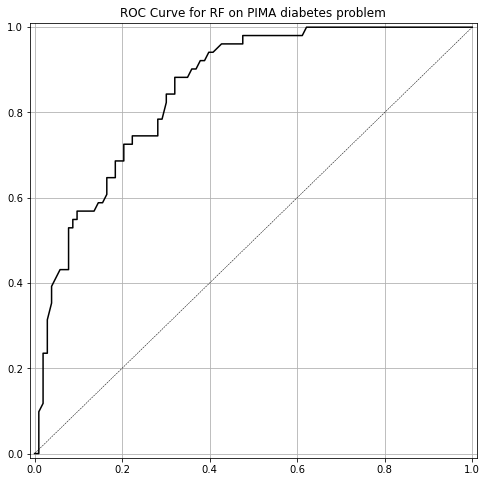

In [12]:
def plot_roc(y_test, rf_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, rf_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, rf_pred_prob[:, 1], 'RF')

### Building a single layer Neural Network

***We need to scale data to use a Neural Network***

In [13]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [14]:
#Define Model
#Input size has 8 columns
#1 hidden layer and 12 nodes
#final layer with just one node with a sigmoid activation since we want it to be between 0-1

model = Sequential()
model.add(Dense(units=12,input_shape=(8,),activation = 'sigmoid'))
model.add(Dense(units=1,activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


***We have 108 at the first layer because we have 8 features + 1 bias = 9 features * 12 inputs = 108***

***We have 12 nodes plus the output so we have 13 parameters here***

In [16]:
#To compile the model
#We are using stochastic gradient descent
#We are using binary cross entropy since we have a binary outcome
model.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=200)

Epoch 1/200
20/20 [==============================] - 1s 9ms/step - loss: 0.7045 - accuracy: 0.4919 - val_loss: 0.6996 - val_accuracy: 0.5455
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6983 - accuracy: 0.5114 - val_loss: 0.6934 - val_accuracy: 0.5844
Epoch 3/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5375 - val_loss: 0.6874 - val_accuracy: 0.6104
Epoch 4/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6886 - accuracy: 0.5684 - val_loss: 0.6819 - val_accuracy: 0.6234
Epoch 5/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6842 - accuracy: 0.5863 - val_loss: 0.6769 - val_accuracy: 0.6429
Epoch 6/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6803 - accuracy: 0.6010 - val_loss: 0.6726 - val_accuracy: 0.6364
Epoch 7/200
20/20 [==============================] - 0s 2ms/step - loss: 0.6769 - accuracy: 0.6205 - val_loss: 0.6688 - val_accuracy: 0.6429
Epoch 8/200
2

In [109]:
y_pred = (model.predict(X_test_sc) > 0.5).astype("int32")
y_pred_prob = model.predict(X_test_sc)

5/5 [==============================] - 0s 936us/step


accuracy is 0.753
roc-auc is 0.830


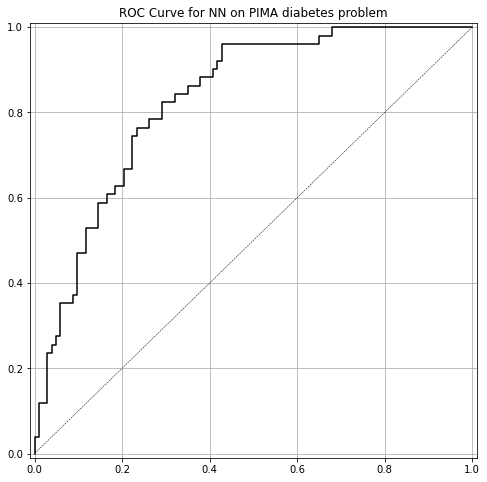

In [111]:
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob)))

plot_roc(y_test, y_pred_prob, 'NN')

***We did a little worse than our random forest model! Lets take a further look at this model***

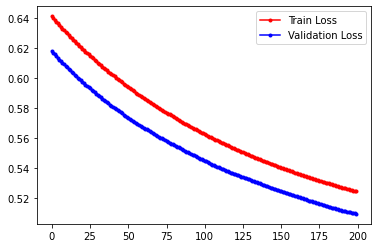

In [113]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

***It appears that loss is continously going down as we train our model, which implies further training and a 
more advanced model can lead to a more accurate model. Lets test that idea***

In [114]:
run_hist_2 = model.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=500)

Epoch 1/500
20/20 [==============================] - 0s 4ms/step - loss: 0.5243 - accuracy: 0.7394 - val_loss: 0.5093 - val_accuracy: 0.7532
Epoch 2/500
20/20 [==============================] - 0s 2ms/step - loss: 0.5240 - accuracy: 0.7394 - val_loss: 0.5090 - val_accuracy: 0.7532
Epoch 3/500
20/20 [==============================] - 0s 2ms/step - loss: 0.5238 - accuracy: 0.7394 - val_loss: 0.5088 - val_accuracy: 0.7532
Epoch 4/500
20/20 [==============================] - 0s 2ms/step - loss: 0.5235 - accuracy: 0.7394 - val_loss: 0.5086 - val_accuracy: 0.7532
Epoch 5/500
20/20 [==============================] - 0s 2ms/step - loss: 0.5233 - accuracy: 0.7394 - val_loss: 0.5084 - val_accuracy: 0.7532
Epoch 6/500
20/20 [==============================] - 0s 2ms/step - loss: 0.5230 - accuracy: 0.7394 - val_loss: 0.5081 - val_accuracy: 0.7468
Epoch 7/500
20/20 [==============================] - 0s 2ms/step - loss: 0.5227 - accuracy: 0.7427 - val_loss: 0.5079 - val_accuracy: 0.7468
Epoch 8/500
2

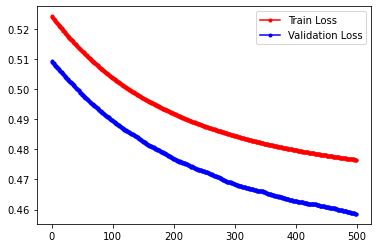

In [115]:
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_2.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

***More training did help with less loss, now lets make a more complex model***

In [117]:
model_2 = Sequential()
model_2.add(Dense(6, input_shape=(8,), activation="relu"))
model_2.add(Dense(6,  activation="relu"))
model_2.add(Dense(1, activation="sigmoid"))

model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=500)

Epoch 1/500
20/20 [==============================] - 0s 7ms/step - loss: 0.8958 - accuracy: 0.3485 - val_loss: 0.8861 - val_accuracy: 0.3571
Epoch 2/500
20/20 [==============================] - 0s 2ms/step - loss: 0.8733 - accuracy: 0.3469 - val_loss: 0.8630 - val_accuracy: 0.3442
Epoch 3/500
20/20 [==============================] - 0s 2ms/step - loss: 0.8520 - accuracy: 0.3485 - val_loss: 0.8430 - val_accuracy: 0.3506
Epoch 4/500
20/20 [==============================] - 0s 2ms/step - loss: 0.8335 - accuracy: 0.3322 - val_loss: 0.8264 - val_accuracy: 0.3571
Epoch 5/500
20/20 [==============================] - 0s 2ms/step - loss: 0.8183 - accuracy: 0.3388 - val_loss: 0.8108 - val_accuracy: 0.3701
Epoch 6/500
20/20 [==============================] - 0s 2ms/step - loss: 0.8041 - accuracy: 0.3550 - val_loss: 0.7970 - val_accuracy: 0.3766
Epoch 7/500
20/20 [==============================] - 0s 2ms/step - loss: 0.7916 - accuracy: 0.3550 - val_loss: 0.7846 - val_accuracy: 0.3896
Epoch 8/500
2

5/5 [==============================] - 0s 1ms/step

accuracy is 0.773
roc-auc is 0.867


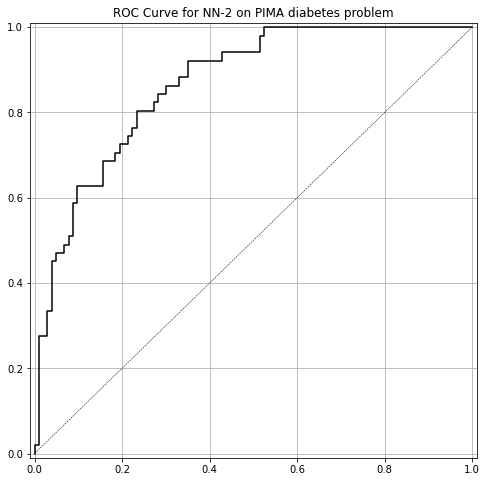

In [118]:
y_pred = (model.predict(X_test_sc) > 0.5).astype("int32")
y_pred_prob = model_2.predict(X_test_sc)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob)))

plot_roc(y_test, y_pred_prob, 'NN-2')

***We improved our accuracy and our ROC curve is better at certain points. Creating a more complex model with longer training 
imporved our overall accuracy***